<a href="https://colab.research.google.com/github/hueglijoshua/CVI03.HS24-Computer-Vision/blob/main/04b_YOLO_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import yaml
import numpy as np
from datetime import datetime
import shutil
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Object detection using YOLO bounding boxes - Part 2

In Part 1 we selected the best performing model, now we are going to test it on unseen test data.

## YOLO Processing Pipeline

1. **Image Preprocessing**  
   - **Resize**: By default, the input image is resized (and sometimes padded with gray bars) to match the model’s expected dimension (e.g., 640×640), preserving aspect ratio.  
   - **Normalization**: Pixel values are typically scaled to [0,1] (e.g., dividing by 255).  

2. **Model Forward Pass**  
   - The processed image is fed into the YOLO model (a convolutional neural network).  
   - The network outputs raw predictions of bounding boxes, class scores, etc.

3. **Postprocessing**  
   - **Confidence threshold**: Confidence represents how sure the model is that the bounding box contains an object of the given class. In YOLOv8 (anchor-free), it’s often interpreted as a probability-like score that the detection is correct. YOLO discards very low-confidence detections. Default threshold is 0.25, but we set could set it even lower. This may increase the the number of found fractures, but on the other hand reduces measures such as the (mean) average precision.
   - **Non-Maximum Suppression (NMS)**: NMS is a post-processing technique used in object detection to remove duplicate and overlapping bounding boxes, keeping only the most confident predictions. It works by first sorting boxes by confidence score, then iteratively selecting the highest-confidence box and suppressing others with high Intersection over Union (IoU). This ensures that each detected object is represented by a single, precise bounding box, improving detection accuracy and reducing redundant predictions. By default, YOLO applies NMS to remove overlapping or duplicate boxes. The default IoU threshold is usually around 0.45 (meaning boxes with an overlap ≥0.45 are suppressed).  
   - The final set of predictions (per class) includes:
     - **(x1, y1, x2, y2)** coordinates for each bounding box  
     - A **confidence** score (0.0 to 1.0)  
     - A **class label** for the predicted object category  


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.2/915.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [119]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/data_object_detection_yolo"

drive_model_dir = "/content/drive/MyDrive/yolo_model_comparison"

## Load the model

The best performing model was the YOLO v8 medium size and freezing 0 layers, which we are now going to load for further evaluation.

In [120]:
best_model = "yolo_v8m_freeze0.pt"
model_path = os.path.join(drive_model_dir, best_model)
# Load the trained model
model = YOLO(model_path)

We can use the following code to evaluate the model on the test results. While these results may slightly deviate from our own calculations, they provide a useful sanity check. For example, if our calculations yield an mAP50 of 0.9, but the values from Ultraytics are significantly lower, it suggests there may be an error somewhere. Despite relying on the provided results, we will still calculate some metrics ourselves to gain deeper insights.

In [90]:
test_results = model.val(imgsz=640, split='test',conf=0.25)

Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/MyDrive/data_object_detection_yolo/labels/test.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all         61         67      0.801      0.493      0.617      0.248
Speed: 8.1ms preprocess, 19.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val2


We create several different functions to allow for detailed analysis. First, we calculate the intersection over union (IoU) and match boxes based on the IoU. These functin will also be used when visualizing selected x-ray images with pedicted and ground truth boxes.

In [8]:
def intersection_over_union(boxA, boxB):
    """
    Computes IoU between two boxes: [xmin, ymin, xmax, ymax].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = boxAArea + boxBArea - interArea + 1e-6

    return interArea / union

def match_boxes_iou(pred_boxes, gt_boxes, iou_thresh):
    """
    Matches predicted boxes with ground truth based on IoU threshold.
    Returns:
      - is_tp: List of booleans indicating if a predicted box is a true positive.
      - is_fp: List of booleans indicating if a predicted box is a false positive.
      - unmatched_gt: Count of unmatched ground truth boxes (False Negatives).
    """
    used = np.zeros(len(gt_boxes), dtype=bool)  # Tracks matched GT boxes
    is_tp = []
    is_fp = []

    for pb in pred_boxes:
        best_iou = 0.0
        best_idx = -1
        for i, gb in enumerate(gt_boxes):
            if used[i]:
                continue  # Skip already matched GT boxes
            iou = intersection_over_union(pb, gb)

            if iou > best_iou:
                best_iou = iou
                best_idx = i

        if best_iou >= iou_thresh and best_idx >= 0:
            is_tp.append(True)
            is_fp.append(False)
            used[best_idx] = True  # Mark this GT as matched
        else:
            is_tp.append(False)
            is_fp.append(True)  # Count this as a false positive

    unmatched_gt = np.sum(~used)  # False Negatives = Unmatched GT boxes
    return np.array(is_tp), np.array(is_fp), unmatched_gt



In [14]:
def load_ground_truth(image_name, img_w, img_h):
    """Loads ground truth bounding boxes for 'fractured' class."""
    label_path = os.path.join(test_labels_dir, os.path.splitext(image_name)[0] + ".txt")
    gt_boxes = []

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                xc, yc, w, h = map(float, parts[1:])
                if cls_id == fractured_id:
                    xmin = int((xc - w/2) * img_w)
                    ymin = int((yc - h/2) * img_h)
                    xmax = int((xc + w/2) * img_w)
                    ymax = int((yc + h/2) * img_h)
                    gt_boxes.append([xmin, ymin, xmax, ymax])
    return gt_boxes

In [15]:
def visualize_detections(dataset_path, folder, image_name,
                         model_path,
                         pred_boxes = None):
    """
    Visualizes ground truth vs. predicted bounding boxes for a given image.

    Parameters:
    - dataset_path (str): Path to the dataset directory.
    - folder (str): The dataset split to use ("train", "val", or "test").
    - image_name (str): The filename of the image (e.g., "IMG0003733.jpg").
    - model_path (str): Path to the trained YOLO model.
    """
    # Define paths for images and labels
    image_path = os.path.join(dataset_path, "images", folder, image_name)
    annotation_path = os.path.join(dataset_path, "labels", folder, os.path.splitext(image_name)[0] + ".txt")

    # Verify the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    print(f"Selected Image: {image_path}")
    print(f"Annotation File: {annotation_path if os.path.exists(annotation_path) else 'No annotation found'}")

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Get image dimensions
    height, width, _ = image.shape

    # Load ground truth bounding boxes
    ground_truth_boxes = load_ground_truth(image_name, width, height)

    if pred_boxes == None:
        # Load trained YOLO model
        model = YOLO(model_path)

        # Run inference on the selected image
        results = model(image_path)

        # Extract predicted bounding boxes
        pred_boxes = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box
                conf = box.conf[0].item()  # Confidence score
                pred_boxes.append((x1, y1, x2, y2, conf))

    # Plot Ground Truth (Green) vs. Predictions (Red)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Plot ground truth bounding boxes (Green)
    for (x1, y1, x2, y2) in ground_truth_boxes:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2))
        plt.text(x1, y1 - 5, f"GT: fractured", color="green", fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Plot predicted bounding boxes (Red)
    for (x1, y1, x2, y2, conf) in pred_boxes:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(x1, y2 + 15, f"Pred: {conf:.2f}", color="red", fontsize=10,
                 verticalalignment='bottom',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.axis("off")
    plt.title("Ground Truth (Green) vs. Predicted (Red)")
    plt.show()

    print(f"Number of Ground Truth Boxes: {len(ground_truth_boxes)}")
    print(f"Number of Predicted Boxes: {len(pred_boxes)}")
    gt_np = np.array([box[:4] for box in ground_truth_boxes])
    pred_np = np.array([box[:4] for box in pred_boxes])

    for i, pbox in enumerate(pred_np):
        best_iou = 0.0
        for gbox in gt_np:
            iou_val = intersection_over_union(pbox, gbox)
            if iou_val > best_iou:
                best_iou = iou_val
        print(f"Predicted box {i} best IoU: {best_iou:.3f}")

## Visualize predicted and ground truth boxes

Selected Image: /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg
Annotation File: /content/drive/MyDrive/data_object_detection_yolo/labels/test/IMG0003713.txt

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 36.6ms
Speed: 3.4ms preprocess, 36.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


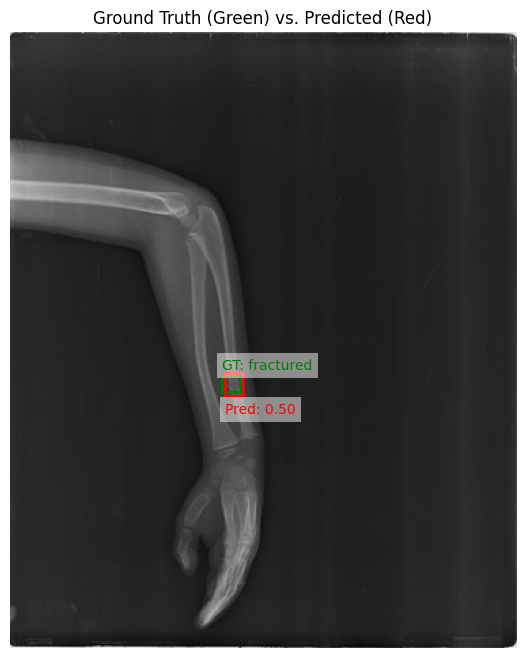

Number of Ground Truth Boxes: 1
Number of Predicted Boxes: 1
Predicted box 0 best IoU: 0.588


In [121]:
import random
folder = 'test'
image_dir = f"{dataset_path}/images/{folder}"
# List all images in the validation folder
image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

random_image = random.choice(image_files)
visualize_detections(dataset_path,folder, random_image, model_path)

Selected Image: /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg
Annotation File: /content/drive/MyDrive/data_object_detection_yolo/labels/test/IMG0003626.txt

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 36.5ms
Speed: 2.3ms preprocess, 36.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


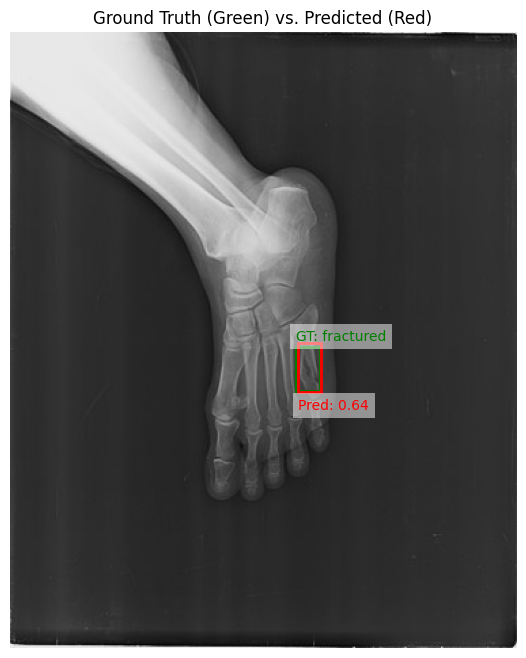

Number of Ground Truth Boxes: 1
Number of Predicted Boxes: 1
Predicted box 0 best IoU: 0.757


In [122]:
visualize_detections(dataset_path, folder, "IMG0003626.jpg", model_path)

## Evaluate results

In [123]:
test_images_dir = f"{dataset_path}/images/test"
test_labels_dir = f"{dataset_path}/labels/test"

model = YOLO(model_path)

test_images = [f for f in os.listdir(test_images_dir)
               if f.lower().endswith((".jpg", ".png", ".jpeg"))]

# We want the class ID for "fractured"
fractured_id = None
for idx, name in model.names.items():
    if name == "fractured":
        fractured_id = idx
        break

if fractured_id is None:
    raise ValueError("No class named 'fractured' in model.names!")

print(f"Class ID for 'fractured': {fractured_id}")

Class ID for 'fractured': 0


In [18]:
def compute_precision_recall_curve(pred_scores, is_tp, is_fp, total_gt_boxes):
    """
    Compute precision-recall values at different confidence thresholds.
    """
    # Sort predictions by confidence score (high to low)
    sorted_indices = np.argsort(-np.array(pred_scores))
    is_tp_sorted = np.array(is_tp)[sorted_indices]
    is_fp_sorted = np.array(is_fp)[sorted_indices]

    # Cumulative sum to compute precision & recall step-by-step
    cum_tp = np.cumsum(is_tp_sorted)
    cum_fp = np.cumsum(is_fp_sorted)

    precision_curve = cum_tp / (cum_tp + cum_fp)  # Precision at each threshold
    recall_curve = cum_tp / total_gt_boxes  # Recall at each threshold

    return precision_curve, recall_curve

def calculate_average_precision(precision: np.array, recall: np.array):
    """
    Calculate the average precision for a given precision-recall curve.
    """
    steps = recall[1:] - recall[:-1]
    average_precision = (steps * precision[:-1]).sum()
    return average_precision

In [36]:
def compute_ap_per_iou(all_gt, all_pred, all_scores, iou_thresholds, model_name, plot = False):
    """Computes AP for different IoU thresholds and plots PR curves."""
    ap_per_iou = {}
    if plot:
        plt.figure(figsize=(8, 6))

    for iou_thresh in iou_thresholds:
        matched_predictions = []
        total_false_negatives = 0

        for gt_boxes, pred_boxes, pred_scores in zip(all_gt, all_pred, all_scores):
            gt_boxes = np.array(gt_boxes)
            pred_boxes = np.array(pred_boxes)
            pred_scores = np.array(pred_scores)

            if len(pred_boxes) == 0:
                total_false_negatives += len(gt_boxes)
                continue

            is_tp, is_fp, fn = match_boxes_iou(pred_boxes, gt_boxes, iou_thresh)
            total_false_negatives += fn

            for tp, fp, s in zip(is_tp, is_fp, pred_scores):
                matched_predictions.append({"score": s, "is_tp": tp, "is_fp": fp})

        if len(matched_predictions) == 0:
            continue

        scores_array = np.array([p["score"] for p in matched_predictions])
        labels_array = np.array([1 if p["is_tp"] else 0 for p in matched_predictions])
        false_positives_array = np.array([1 if p["is_fp"] else 0 for p in matched_predictions])

        precision_curve, recall_curve = compute_precision_recall_curve(
            scores_array, labels_array, false_positives_array, 67
        )

        precision_recall = np.column_stack((precision_curve, recall_curve))
        precision_recall_interpolated = np.array(
            [
                (precision_recall[i:, 0].max(), precision_recall[i, 1])
                for i in range(precision_recall.shape[0] - 1)
            ]
        )

        ap = calculate_average_precision(
            precision_recall_interpolated[:, 0], precision_recall_interpolated[:, 1]
        )
        ap_per_iou[iou_thresh] = ap
        if plot:
            plt.plot(
                precision_recall_interpolated[:, 1],
                precision_recall_interpolated[:, 0],
                label=f"IoU={iou_thresh:.2f}",
            )

    if plot:
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curves ({model_name})")
        plt.grid(True)
        plt.legend()
        plt.show()

    return ap_per_iou

In [142]:
def compute_confusion_matrix(all_gt, all_pred, model_name, axes):
    """
    Computes and displays a 2x2 confusion matrix (TP, FP, FN, TN) for a specific model.
    This version includes no-fracture images as true negatives and counts
    each predicted box on a no-fracture image as a false positive.
    """

    y_true = []
    y_pred = []

    # Loop through each image
    for gt_boxes, pred_boxes in zip(all_gt, all_pred):
        # CASE 1: No GT boxes
        if len(gt_boxes) == 0:
            # If the model also predicts no boxes => Single True Negative
            if len(pred_boxes) == 0:
                y_true.append(0)  # Actual: no fracture
                y_pred.append(0)  # Predicted: no fracture
            else:
                # If the model predicts >=1 box => each one is a False Positive
                for _ in pred_boxes:
                    y_true.append(0)  # Actual: no fracture
                    y_pred.append(1)  # Predicted: fracture
        else:
            # CASE 2: One or more GT boxes (standard matching)
            # Track which GT boxes have been matched
            gt_used = [False] * len(gt_boxes)

            # For each predicted box, find the best GT match (if any)
            for pbox in pred_boxes:
                best_iou = 0.0
                best_idx = -1
                for i, gt_box in enumerate(gt_boxes):
                    if not gt_used[i]:
                        iou_val = intersection_over_union(pbox, gt_box)
                        if iou_val > best_iou:
                            best_iou = iou_val
                            best_idx = i

                if best_iou >= 0.5 and best_idx >= 0:
                    # True Positive
                    gt_used[best_idx] = True
                    y_true.append(1)  # Actual: fracture
                    y_pred.append(1)  # Predicted: fracture
                else:
                    # No match => False Positive
                    y_true.append(0)  # Actual: no fracture (for this "box" perspective)
                    y_pred.append(1)  # Predicted: fracture

            # Any ground-truth box left unmatched => False Negative
            for i, used in enumerate(gt_used):
                if not used:
                    y_true.append(1)  # Actual: fracture
                    y_pred.append(0)  # Predicted: no fracture

    # Build confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

    # Extract values
    TP, FN = cm[0, 0], cm[0, 1]
    FP, TN = cm[1, 0], cm[1, 1]

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN + 1e-6) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP + 1e-6) if (TN + FP) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6) if (precision + recall) > 0 else 0.0

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Fracture Found", "No Fracture Found"])

    # Plot on either a given Axes or a new figure
    if axes is not None:
        disp.plot(cmap=plt.cm.Blues, ax=axes, colorbar=False)
        axes.set_title(f"{model_name.strip('.pt')}, IoU>=0.5")
        axes.set_yticklabels(["Fracture Found", "No Fracture Found"], rotation=90, va='center')

        # Add metrics as text below the confusion matrix
        metrics_text = f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nSpecificity: {specificity:.2f}\nF1-score: {f1_score:.2f}"
        axes.text(0.5, -0.4, metrics_text, fontsize=12, ha='center', va='center', transform=axes.transAxes)
    else:
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name.strip('.pt')}, IoU>=0.5")
        plt.gca().set_yticklabels(["Fracture Found", "No Fracture Found"], rotation=90, va='center')

        # Add metrics as text below the confusion matrix
        plt.figtext(0.5, -0.1, f"Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f} | F1-score: {f1_score:.2f}",
                    ha="center", fontsize=12)
        plt.show()

In [21]:
def run_model(model, image_path):
    """Runs a YOLO model on the given image and returns predicted boxes and scores."""
    results = model(image_path, imgsz=640, conf=0.25)

    pred_boxes = []
    scores = []
    for r in results:
        for box in r.boxes:
            cls_pred = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            if cls_pred == fractured_id:
                pred_boxes.append([x1, y1, x2, y2])
                scores.append(conf)

    return pred_boxes, scores

In the next step, we loop through all our test images and saved ground truth boxes, predicted boxes and scores in dedicated lists.

In [124]:
all_gt = []
all_pred = []
all_scores = []

for image_name in tqdm(test_images):
    image_path = os.path.join(test_images_dir, image_name)
    image = cv2.imread(image_path)
    if image is None:
        continue  # Skip broken image
    img_h, img_w = image.shape[:2]

    gt_boxes = load_ground_truth(image_name, img_w, img_h)
    pred_boxes, scores = run_model(model, image_path)

    all_gt.append(gt_boxes)
    all_pred.append(pred_boxes)
    all_scores.append(scores)

  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 37.4ms
Speed: 3.9ms preprocess, 37.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:35,  1.70it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 (no detections), 35.8ms
Speed: 3.5ms preprocess, 35.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 2 fractureds, 28.0ms
Speed: 3.6ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


  5%|▍         | 3/61 [00:00<00:11,  5.12it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 27.2ms
Speed: 3.6ms preprocess, 27.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 27.1ms
Speed: 3.4ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


  8%|▊         | 5/61 [00:00<00:06,  8.11it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 27.1ms
Speed: 3.4ms preprocess, 27.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 1 fractured, 21.8ms
Speed: 3.6ms preprocess, 21.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 1 fractured, 21.3ms
Speed: 3.6ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 8/61 [00:00<00:04, 12.00it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 1 fractured, 20.7ms
Speed: 3.3ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 2 fractureds, 20.6ms
Speed: 3.3ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 20.0ms
Speed: 3.5ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 11/61 [00:01<00:03, 14.94it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 2 fractureds, 19.1ms
Speed: 3.9ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 2 fractureds, 20.0ms
Speed: 4.2ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 13/61 [00:01<00:03, 15.67it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 18.7ms
Speed: 3.5ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 18.9ms
Speed: 3.5ms preprocess, 18.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 18.6ms
Speed: 3.9ms preprocess, 18.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 16/61 [00:01<00:02, 17.45it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 3 fractureds, 18.6ms
Speed: 3.4ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 18.9ms
Speed: 3.2ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 (no detections), 18.6ms
Speed: 3.3ms preprocess, 18.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 19/61 [00:01<00:02, 19.07it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 17.2ms
Speed: 3.3ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 17.2ms
Speed: 4.9ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 17.1ms
Speed: 4.6ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▌      | 22/61 [00:01<00:01, 20.36it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 1 fractured, 17.1ms
Speed: 3.3ms preprocess, 17.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 (no detections), 17.0ms
Speed: 3.5ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 17.0ms
Speed: 3.5ms preprocess, 17.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 25/61 [00:01<00:01, 21.56it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 17.2ms
Speed: 3.5ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 17.2ms
Speed: 3.6ms preprocess, 17.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 17.3ms
Speed: 3.4ms preprocess, 17.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 28/61 [00:01<00:01, 22.61it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 17.2ms
Speed: 3.7ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 31/61 [00:01<00:01, 23.30it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 2 fractureds, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 56%|█████▌    | 34/61 [00:02<00:01, 23.16it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 18.3ms
Speed: 3.5ms preprocess, 18.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 1 fractured, 18.3ms
Speed: 3.3ms preprocess, 18.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 17.5ms
Speed: 4.2ms preprocess, 17.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 37/61 [00:02<00:01, 23.04it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 22.1ms
Speed: 3.4ms preprocess, 22.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 1 fractured, 18.2ms
Speed: 5.0ms preprocess, 18.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 2 fractureds, 23.3ms
Speed: 3.5ms preprocess, 23.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 40/61 [00:02<00:00, 21.89it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 18.4ms
Speed: 3.5ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 17.3ms
Speed: 3.3ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 17.5ms
Speed: 5.5ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 43/61 [00:02<00:00, 21.80it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 (no detections), 16.3ms
Speed: 3.7ms preprocess, 16.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 16.5ms
Speed: 4.8ms preprocess, 16.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 16.4ms
Speed: 3.4ms preprocess, 16.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 46/61 [00:02<00:00, 22.50it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 24.6ms
Speed: 4.3ms preprocess, 24.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 19.9ms
Speed: 4.4ms preprocess, 19.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 21.0ms
Speed: 3.6ms preprocess, 21.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 49/61 [00:02<00:00, 21.84it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 16.1ms
Speed: 5.5ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 19.2ms
Speed: 3.4ms preprocess, 19.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 2 fractureds, 16.4ms
Speed: 3.4ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 52/61 [00:02<00:00, 21.97it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 17.0ms
Speed: 4.6ms preprocess, 17.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 16.4ms
Speed: 3.3ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 55/61 [00:03<00:00, 21.81it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 2 fractureds, 16.6ms
Speed: 3.8ms preprocess, 16.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 16.2ms
Speed: 4.5ms preprocess, 16.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 20.5ms
Speed: 4.6ms preprocess, 20.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 58/61 [00:03<00:00, 21.88it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 (no detections), 18.7ms
Speed: 3.4ms preprocess, 18.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 19.6ms
Speed: 4.6ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 1 fractured, 16.6ms
Speed: 4.5ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:03<00:00, 18.31it/s]


We know that we have 61 test images, so let's check if our 3 lists vontain 61 elements:

In [125]:
print(len(all_gt), len(all_pred), len(all_scores))

61 61 61


We compute the Average Precision (AP) across IoU thresholds ranging from 0.5 to 1.0 and visualize the results using a Precision-Recall curve.

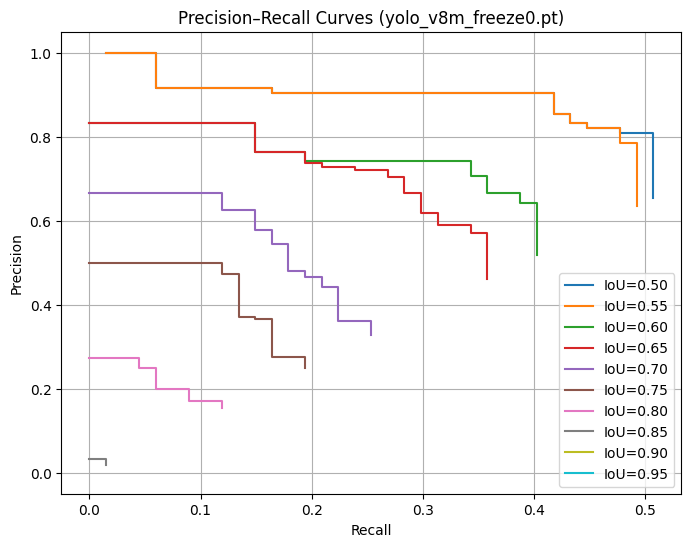

In [126]:
# Compute metrics
iou_thresholds = np.arange(0.5, 1.0, 0.05)
ap_per_iou = compute_ap_per_iou(
    all_gt, all_pred, all_scores, iou_thresholds, best_model, plot = True
)

In [127]:
for iou, ap in ap_per_iou.items():
    print(f"IoU {iou:.2f}: AP = {ap:.3f}")

mean_ap = np.mean(list(ap_per_iou.values()))
print(f"Mean Average Precision (mAP50-95): {mean_ap:.3f}")

IoU 0.50: AP = 0.444
IoU 0.55: AP = 0.431
IoU 0.60: AP = 0.309
IoU 0.65: AP = 0.269
IoU 0.70: AP = 0.147
IoU 0.75: AP = 0.086
IoU 0.80: AP = 0.027
IoU 0.85: AP = 0.000
IoU 0.90: AP = 0.000
IoU 0.95: AP = 0.000
Mean Average Precision (mAP50-95): 0.171


For the unseen test data the model has a mean Average Precision (mAP50-95) of 0.171 and the average precision at an IoU>0.5 is 0.44. These values are smaller compared to the validation data.

## Confusion matrix

We create a confusion matrix based on whether the model detected a box with IoU>=0.5 to that of the ground truth.

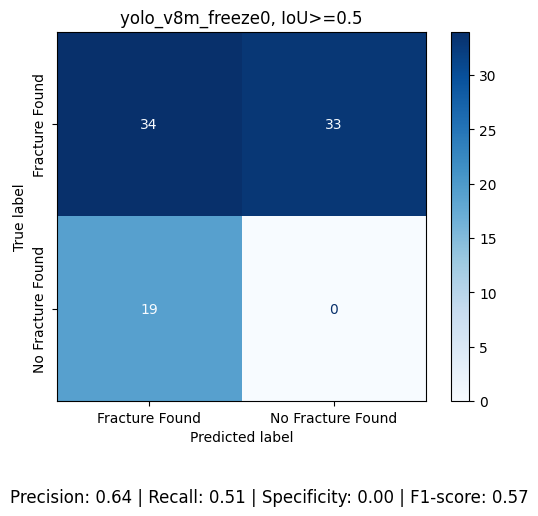

In [137]:
compute_confusion_matrix(
    all_gt, all_pred, best_model, axes = None
)

**Fractures in the Dataset**
- **True Positives (TP) = 34**: These are correctly detected fractures. The model predicted a fracture where an actual fracture exists.  
- **False Negatives (FN) = 33**: These are missed fractures. The model failed to detect these actual fractures, which would be an issue in medical applications.

**No Fractures in the Dataset**
- **False Positives (FP) = 19**: These are incorrect detections. The model predicted a fracture when there was none.  
- **True Negatives (TN) = 0**: Since the dataset does not contain any images without fractures, the model was never tested on truly negative cases.

**Perfomance Metrics**
- Precision: When the model predicts a fracture, it is correct 64% of the time.
- Recall (Sensitivity): The model correctly identifies 51% of actual fractures.
- Specificity: Since there are no images without fractures in the dataset, true negatives cannot be calculated. This means we cannot measure the model’s ability to correctly classify "no fracture" images.
- F1 Score: balance between Precision and Recall - 57%

The results are not very convincing.  So in the next step we are going to compare the top 5 models from Part 1.

## Comparing the Top 5 models

In [140]:
def evaluate_models(models, test_images, drive_model_dir, test_images_dir):
    """Loads models, runs evaluation, and computes metrics."""
    model_results_dict = {}

    # Create subplots with dynamic size
    fig, axes = plt.subplots(1, len(models), figsize=(4 * len(models), 5))

    # Ensure axes is iterable even if there is only one model
    if len(models) == 1:
        axes = [axes]

    for idx, model_name in enumerate(models):
        print(f"\nLoading Model: {model_name}")
        model_path = os.path.join(drive_model_dir, model_name)
        model = YOLO(model_path)

        results_dict = {"gt": [], "pred": [], "scores": []}

        for image_name in tqdm(test_images):
            image_path = os.path.join(test_images_dir, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip broken image
            img_h, img_w = image.shape[:2]

            # Load ground truth
            gt_boxes = load_ground_truth(image_name, img_w, img_h)
            results_dict["gt"].append(gt_boxes)

            # Run model and store predictions
            pred_boxes, scores = run_model(model, image_path)
            results_dict["pred"].append(pred_boxes)
            results_dict["scores"].append(scores)

        # Compute metrics
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
        print(f"Evaluating Model: {model_name}")
        ap_per_iou = compute_ap_per_iou(
            results_dict["gt"], results_dict["pred"], results_dict["scores"], iou_thresholds,
            model_name, plot=False
        )

        # Store results
        model_results_dict[model_name.strip(".pt")] = ap_per_iou

        # Compute and plot confusion matrix in the corresponding subplot
        compute_confusion_matrix(results_dict["gt"], results_dict["pred"], model_name, axes[idx])

    plt.tight_layout()
    plt.show()

    return model_results_dict


Loading Model: yolo_v8m_freeze0.pt


  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 37.0ms
Speed: 3.2ms preprocess, 37.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:23,  2.56it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 (no detections), 34.6ms
Speed: 2.7ms preprocess, 34.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 2 fractureds, 34.2ms
Speed: 3.0ms preprocess, 34.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


  5%|▍         | 3/61 [00:00<00:08,  7.06it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 34.2ms
Speed: 2.1ms preprocess, 34.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 34.2ms
Speed: 2.1ms preprocess, 34.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


  8%|▊         | 5/61 [00:00<00:05, 10.34it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 22.5ms
Speed: 2.3ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 1 fractured, 22.4ms
Speed: 2.1ms preprocess, 22.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 1 fractured, 22.4ms
Speed: 2.1ms preprocess, 22.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 8/61 [00:00<00:03, 14.77it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 1 fractured, 21.7ms
Speed: 3.1ms preprocess, 21.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 2 fractureds, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 11/61 [00:00<00:02, 17.10it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 2 fractureds, 19.3ms
Speed: 2.2ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 2 fractureds, 18.8ms
Speed: 3.2ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 18.8ms
Speed: 3.1ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 23%|██▎       | 14/61 [00:00<00:02, 19.55it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 18.3ms
Speed: 3.0ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.6ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 3 fractureds, 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 17/61 [00:01<00:02, 21.34it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 (no detections), 16.5ms
Speed: 3.5ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.9ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 20/61 [00:01<00:01, 22.72it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 16.9ms
Speed: 2.5ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.5ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 23/61 [00:01<00:01, 23.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 (no detections), 16.2ms
Speed: 3.4ms preprocess, 16.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 16.2ms
Speed: 3.6ms preprocess, 16.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 26/61 [00:01<00:01, 24.00it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 16.3ms
Speed: 3.1ms preprocess, 16.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 16.5ms
Speed: 3.1ms preprocess, 16.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 29/61 [00:01<00:01, 24.83it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 2 fractureds, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 32/61 [00:01<00:01, 24.73it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 1 fractured, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 35/61 [00:01<00:01, 25.70it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 17.5ms
Speed: 2.1ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 62%|██████▏   | 38/61 [00:01<00:00, 26.54it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 1 fractured, 17.3ms
Speed: 2.1ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 2 fractureds, 18.7ms
Speed: 3.0ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 41/61 [00:02<00:00, 26.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 18.0ms
Speed: 2.5ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.5ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 (no detections), 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 44/61 [00:02<00:00, 26.45it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 16.7ms
Speed: 2.5ms preprocess, 16.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 47/61 [00:02<00:00, 26.61it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 50/61 [00:02<00:00, 26.35it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 16.4ms
Speed: 3.4ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 2 fractureds, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 16.6ms
Speed: 2.8ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 53/61 [00:02<00:00, 24.79it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 1 fractured, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 2 fractureds, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 92%|█████████▏| 56/61 [00:02<00:00, 25.50it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 (no detections), 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 59/61 [00:02<00:00, 26.34it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.1ms preprocess, 16.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 1 fractured, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:02<00:00, 21.91it/s]

Evaluating Model: yolo_v8m_freeze0.pt



Loading Model: yolo_v8m_freeze10.pt


  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 16.9ms
Speed: 3.2ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:22,  2.64it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 1 fractured, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 16.1ms
Speed: 2.5ms preprocess, 16.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 4/61 [00:00<00:05,  9.86it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 16.6ms
Speed: 6.9ms preprocess, 16.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 16.5ms
Speed: 3.1ms preprocess, 16.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 1 fractured, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 11%|█▏        | 7/61 [00:00<00:03, 14.75it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 (no detections), 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▋        | 10/61 [00:00<00:02, 17.84it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 2 fractureds, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 13/61 [00:00<00:02, 20.80it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 16.8ms
Speed: 3.4ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 16/61 [00:00<00:01, 22.77it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 2 fractureds, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 17.5ms
Speed: 3.2ms preprocess, 17.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 19/61 [00:01<00:01, 23.94it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 16.3ms
Speed: 3.5ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 16.4ms
Speed: 3.0ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▌      | 22/61 [00:01<00:01, 24.49it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 (no detections), 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 1 fractured, 16.0ms
Speed: 2.5ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 25/61 [00:01<00:01, 24.95it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.6ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 16.3ms
Speed: 4.0ms preprocess, 16.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 28/61 [00:01<00:01, 25.10it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 16.2ms
Speed: 3.8ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 16.2ms
Speed: 3.0ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 18.8ms
Speed: 2.6ms preprocess, 18.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 31/61 [00:01<00:01, 24.00it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.8ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 (no detections), 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 2 fractureds, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 56%|█████▌    | 34/61 [00:01<00:01, 24.46it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 37/61 [00:01<00:00, 25.36it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 (no detections), 17.9ms
Speed: 2.2ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 1 fractured, 16.8ms
Speed: 3.2ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 40/61 [00:01<00:00, 25.83it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 43/61 [00:01<00:00, 26.23it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 16.9ms
Speed: 2.6ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 46/61 [00:02<00:00, 26.54it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 16.2ms
Speed: 3.5ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 49/61 [00:02<00:00, 26.00it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 15.9ms
Speed: 2.8ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 2 fractureds, 16.3ms
Speed: 2.7ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 52/61 [00:02<00:00, 25.15it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 16.8ms
Speed: 3.7ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 3 fractureds, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 55/61 [00:02<00:00, 25.67it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 58/61 [00:02<00:00, 26.49it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 (no detections), 16.3ms
Speed: 2.9ms preprocess, 16.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 16.0ms
Speed: 2.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 1 fractured, 17.0ms
Speed: 2.4ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:02<00:00, 22.78it/s]

Evaluating Model: yolo_v8m_freeze10.pt

Loading Model: yolo_v8m_freezeall.pt



  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 18.9ms
Speed: 2.9ms preprocess, 18.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:22,  2.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.7ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 2 fractureds, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 4/61 [00:00<00:05,  9.90it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 1 fractured, 16.4ms
Speed: 3.5ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 11%|█▏        | 7/61 [00:00<00:03, 15.05it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 (no detections), 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▋        | 10/61 [00:00<00:02, 17.93it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 2 fractureds, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 1 fractured, 15.9ms
Speed: 3.4ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 13/61 [00:00<00:02, 20.52it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 16/61 [00:00<00:01, 22.60it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 2 fractureds, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.2ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 1 fractured, 16.7ms
Speed: 4.2ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 19/61 [00:01<00:01, 23.65it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▌      | 22/61 [00:01<00:01, 24.90it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 2 fractureds, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 25/61 [00:01<00:01, 25.56it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 16.8ms
Speed: 3.2ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 16.5ms
Speed: 3.2ms preprocess, 16.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 46%|████▌     | 28/61 [00:01<00:01, 25.81it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 16.0ms
Speed: 2.6ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 31/61 [00:01<00:01, 24.45it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 2 fractureds, 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 (no detections), 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 1 fractured, 16.4ms
Speed: 3.1ms preprocess, 16.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)


 56%|█████▌    | 34/61 [00:01<00:01, 24.84it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 16.7ms
Speed: 2.9ms preprocess, 16.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 2 fractureds, 16.9ms
Speed: 2.6ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 37/61 [00:01<00:00, 25.32it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 17.5ms
Speed: 3.7ms preprocess, 17.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 (no detections), 17.3ms
Speed: 3.9ms preprocess, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 1 fractured, 19.3ms
Speed: 5.4ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


 66%|██████▌   | 40/61 [00:01<00:00, 24.23it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 15.8ms
Speed: 3.3ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 17.4ms
Speed: 3.4ms preprocess, 17.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 2 fractureds, 16.8ms
Speed: 3.4ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 43/61 [00:02<00:00, 24.75it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 1 fractured, 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 17.0ms
Speed: 3.2ms preprocess, 17.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 17.6ms
Speed: 5.6ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 46/61 [00:02<00:00, 24.29it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 16.3ms
Speed: 4.2ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 16.3ms
Speed: 6.3ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 49/61 [00:02<00:00, 23.08it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 17.9ms
Speed: 3.2ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 16.4ms
Speed: 3.5ms preprocess, 16.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 1 fractured, 16.3ms
Speed: 4.5ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 52/61 [00:02<00:00, 22.02it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 16.6ms
Speed: 4.4ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 (no detections), 16.3ms
Speed: 3.2ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 2 fractureds, 16.3ms
Speed: 3.2ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 55/61 [00:02<00:00, 22.54it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 2 fractureds, 16.3ms
Speed: 3.4ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 1 fractured, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 16.3ms
Speed: 3.6ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 58/61 [00:02<00:00, 22.94it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 2 fractureds, 16.2ms
Speed: 3.4ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 16.2ms
Speed: 3.4ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 (no detections), 16.6ms
Speed: 3.4ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:02<00:00, 21.71it/s]

Evaluating Model: yolo_v8m_freezeall.pt

Loading Model: yolo_v8s_freeze10.pt



  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 9.4ms
Speed: 4.3ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:17,  3.40it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 (no detections), 10.7ms
Speed: 3.3ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 1 fractured, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 4/61 [00:00<00:04, 11.81it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 10.3ms
Speed: 4.2ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 1 fractured, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 11%|█▏        | 7/61 [00:00<00:03, 17.28it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 (no detections), 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 (no detections), 9.5ms
Speed: 3.5ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 (no detections), 9.3ms
Speed: 3.5ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▋        | 10/61 [00:00<00:02, 20.58it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 2 fractureds, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 (no detections), 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 (no detections), 8.1ms
Speed: 5.5ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 7.9ms
Speed: 5.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 23%|██▎       | 14/61 [00:00<00:01, 24.29it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 10.9ms
Speed: 3.3ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 2 fractureds, 11.8ms
Speed: 3.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 17/61 [00:00<00:01, 24.62it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 14.0ms
Speed: 4.6ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 1 fractured, 11.8ms
Speed: 4.6ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 16.8ms
Speed: 5.0ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 20/61 [00:00<00:01, 24.08it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 2 fractureds, 13.6ms
Speed: 3.2ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 (no detections), 13.6ms
Speed: 3.4ms preprocess, 13.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 23/61 [00:01<00:01, 23.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 1 fractured, 14.7ms
Speed: 3.5ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 19.5ms
Speed: 3.2ms preprocess, 19.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 14.2ms
Speed: 3.6ms preprocess, 14.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 26/61 [00:01<00:01, 23.16it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 15.6ms
Speed: 3.7ms preprocess, 15.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 10.9ms
Speed: 3.6ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 20.6ms
Speed: 3.2ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 29/61 [00:01<00:01, 23.55it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 10.7ms
Speed: 6.8ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 18.1ms
Speed: 3.2ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 1 fractured, 13.7ms
Speed: 3.3ms preprocess, 13.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 32/61 [00:01<00:01, 22.82it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 (no detections), 14.9ms
Speed: 3.2ms preprocess, 14.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 1 fractured, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 10.9ms
Speed: 3.6ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 35/61 [00:01<00:01, 24.20it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 3 fractureds, 12.9ms
Speed: 3.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 2 fractureds, 11.1ms
Speed: 3.7ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 12.8ms
Speed: 6.0ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 62%|██████▏   | 38/61 [00:01<00:00, 25.58it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 (no detections), 14.4ms
Speed: 3.5ms preprocess, 14.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 1 fractured, 17.4ms
Speed: 3.4ms preprocess, 17.4ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 41/61 [00:01<00:00, 24.93it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 14.1ms
Speed: 3.2ms preprocess, 14.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 (no detections), 15.8ms
Speed: 3.2ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 (no detections), 12.6ms
Speed: 3.3ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 44/61 [00:01<00:00, 24.88it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 13.7ms
Speed: 4.0ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 20.2ms
Speed: 3.3ms preprocess, 20.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 11.7ms
Speed: 3.4ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 47/61 [00:02<00:00, 23.73it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 15.2ms
Speed: 6.1ms preprocess, 15.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 15.5ms
Speed: 3.3ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 11.5ms
Speed: 3.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████▏ | 50/61 [00:02<00:00, 24.17it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 87%|████████▋ | 53/61 [00:02<00:00, 25.31it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 (no detections), 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 1 fractured, 11.8ms
Speed: 3.5ms preprocess, 11.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 57/61 [00:02<00:00, 27.83it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 (no detections), 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:02<00:00, 23.57it/s]

Evaluating Model: yolo_v8s_freeze10.pt

Loading Model: yolo_v8n_freeze10.pt



  0%|          | 0/61 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 1/61 [00:00<00:08,  7.45it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003339.jpg: 640x544 1 fractured, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003588.jpg: 640x544 2 fractureds, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003671.jpg: 640x544 2 fractureds, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 4/61 [00:00<00:03, 18.64it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 9.4ms
Speed: 3.6ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003342.jpg: 640x544 2 fractureds, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003312.jpg: 640x544 (no detections), 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 8/61 [00:00<00:02, 24.91it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003374.jpg: 640x544 1 fractured, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003619.jpg: 640x544 (no detections), 9.8ms
Speed: 4.1ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 11/61 [00:00<00:01, 25.68it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003311.jpg: 640x544 2 fractureds, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003297.jpg: 640x544 (no detections), 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▍       | 15/61 [00:00<00:01, 28.81it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003509.jpg: 640x544 1 fractured, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003712.jpg: 640x544 2 fractureds, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003419.jpg: 640x544 1 fractured, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 19/61 [00:00<00:01, 32.04it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003589.jpg: 640x544 1 fractured, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 23/61 [00:00<00:01, 34.42it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003331.jpg: 640x544 1 fractured, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 14.4ms
Speed: 2.2ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003625.jpg: 640x544 2 fractureds, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003301.jpg: 640x544 1 fractured, 12.4ms
Speed: 3.4ms preprocess, 12.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 27/61 [00:00<00:01, 33.67it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 6.7ms
Speed: 3.0ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 51%|█████     | 31/61 [00:01<00:00, 33.44it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003459.jpg: 640x544 4 fractureds, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003310.jpg: 640x544 (no detections), 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003399.jpg: 640x544 1 fractured, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003373.jpg: 640x544 1 fractured, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 35/61 [00:01<00:00, 34.25it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003382.jpg: 640x544 1 fractured, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003564.jpg: 640x544 2 fractureds, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003309.jpg: 544x640 1 fractured, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003394.jpg: 640x544 (no detections), 10.4ms
Speed: 2.5ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 39/61 [00:01<00:00, 33.71it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003628.jpg: 544x640 1 fractured, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003341.jpg: 544x640 3 fractureds, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 10.3ms
Speed: 3.5ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 43/61 [00:01<00:00, 33.55it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003477.jpg: 640x544 (no detections), 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003565.jpg: 640x544 2 fractureds, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 47/61 [00:01<00:00, 32.88it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003467.jpg: 640x544 2 fractureds, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003396.jpg: 640x544 (no detections), 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 84%|████████▎ | 51/61 [00:01<00:00, 32.91it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003520.jpg: 640x544 1 fractured, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 13.8ms
Speed: 3.2ms preprocess, 13.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003338.jpg: 640x544 (no detections), 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 55/61 [00:01<00:00, 31.53it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003308.jpg: 640x544 2 fractureds, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003545.jpg: 640x544 3 fractureds, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 97%|█████████▋| 59/61 [00:01<00:00, 32.15it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003703.jpg: 640x544 2 fractureds, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_yolo/images/test/IMG0003420.jpg: 544x640 1 fractured, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 61/61 [00:01<00:00, 31.01it/s]

Evaluating Model: yolo_v8n_freeze10.pt


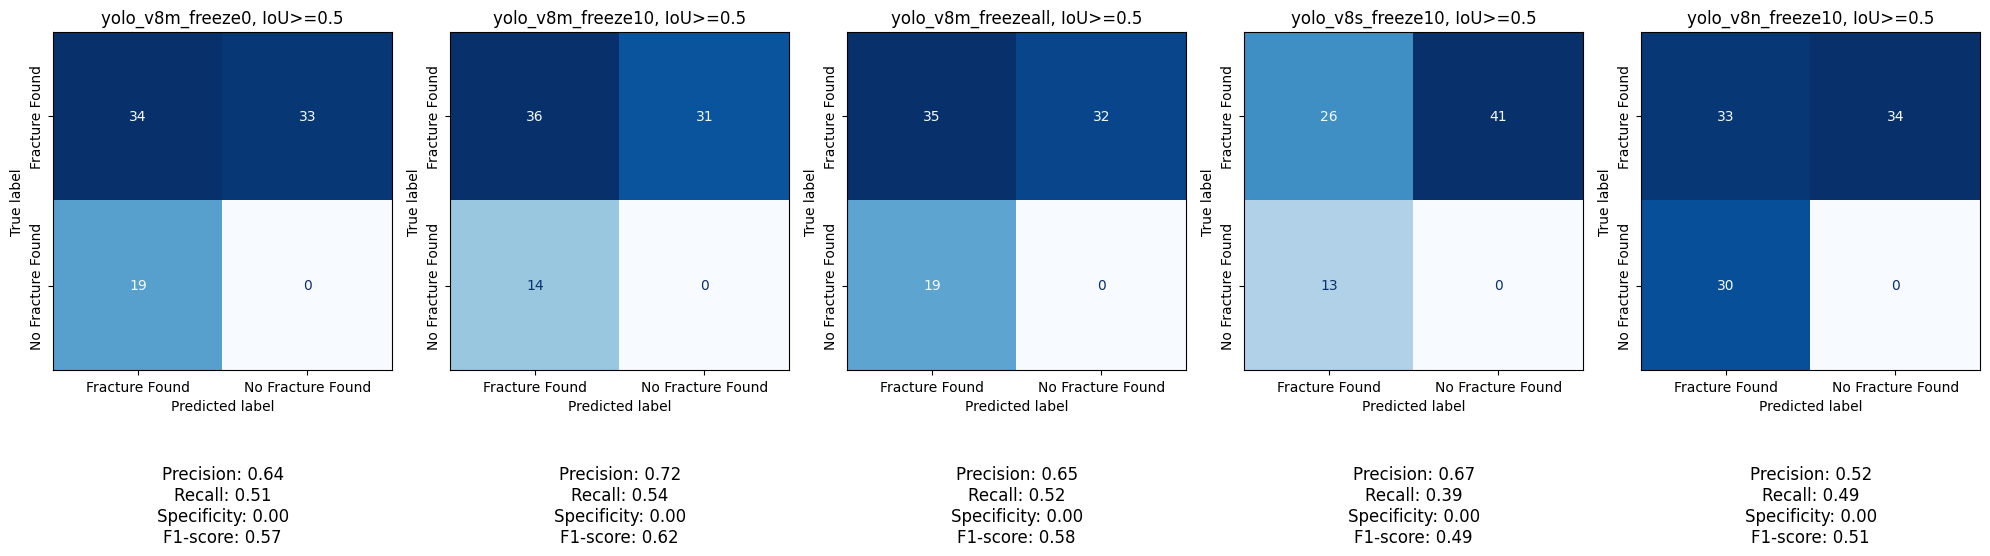

In [143]:
models = [
    "yolo_v8m_freeze0.pt",
    "yolo_v8m_freeze10.pt",
    "yolo_v8m_freezeall.pt",
    "yolo_v8s_freeze10.pt",
    "yolo_v8n_freeze10.pt"]

eval_results = evaluate_models(models, test_images, drive_model_dir, test_images_dir)

In [144]:
df_results = pd.DataFrame(eval_results)
df_results

,yolo_v8m_freeze0,yolo_v8m_freeze10,yolo_v8m_freezeall,yolo_v8s_freeze10,yolo_v8n_freeze10
0.50,0.443550,0.477085,0.452074,0.319791,0.392485
0.55,0.431112,0.335007,0.396726,0.319791,0.348156
0.60,0.309386,0.285353,0.260332,0.285416,0.283248
0.65,0.268623,0.227576,0.225041,0.220463,0.217467
0.70,0.146574,0.148439,0.188391,0.199923,0.128316
0.75,0.086029,0.088455,0.147927,0.129657,0.077736
0.80,0.026994,0.024550,0.032172,0.092633,0.058319
0.85,0.000498,0.000597,0.021559,0.016418,0.018218
0.90,0.000000,0.000597,0.001658,0.007463,0.003622
0.95,0.000000,0.000000,0.000000,0.000000,0.000000


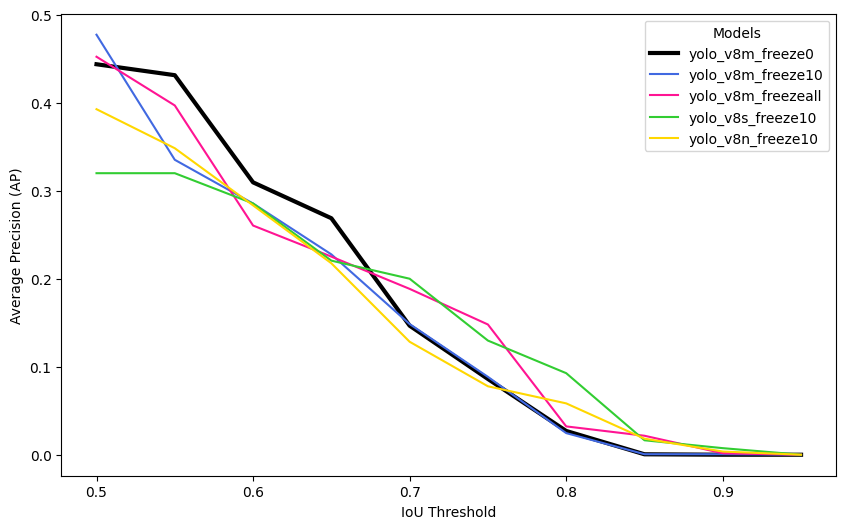

In [145]:
# Define colors for the remaining models
colors = ['black','royalblue', 'deeppink', 'limegreen', 'gold']

plt.figure(figsize=(10, 6))

# Plot the first column in black with linewidth 2
plt.plot(df_results.index, df_results[df_results.columns[0]], linestyle='-', color=colors[0], linewidth=3, label=df_results.columns[0])

# Plot the remaining columns in different shades of blue
for i, column in enumerate(df_results.columns[1:]):
    plt.plot(df_results.index, df_results[column], linestyle='-', color=colors[i+1], linewidth=1.5, label=column)

plt.xlabel("IoU Threshold")
plt.ylabel("Average Precision (AP)")
plt.legend(title="Models", loc="upper right")
plt.grid(False)
plt.show()


In [146]:
# Create a new row with the calculated means and name it "mAP50-95"
mAP_row = pd.DataFrame({'mAP50-95': df_results.mean(axis=0)})

df_results_mAP = pd.concat([df_results, mAP_row.T], ignore_index=False)
df_results_mAP



,yolo_v8m_freeze0,yolo_v8m_freeze10,yolo_v8m_freezeall,yolo_v8s_freeze10,yolo_v8n_freeze10
0.5,0.443550,0.477085,0.452074,0.319791,0.392485
0.55,0.431112,0.335007,0.396726,0.319791,0.348156
0.6,0.309386,0.285353,0.260332,0.285416,0.283248
0.65,0.268623,0.227576,0.225041,0.220463,0.217467
0.7,0.146574,0.148439,0.188391,0.199923,0.128316
0.75,0.086029,0.088455,0.147927,0.129657,0.077736
0.8,0.026994,0.024550,0.032172,0.092633,0.058319
0.85,0.000498,0.000597,0.021559,0.016418,0.018218
0.9,0.000000,0.000597,0.001658,0.007463,0.003622
0.95,0.000000,0.000000,0.000000,0.000000,0.000000


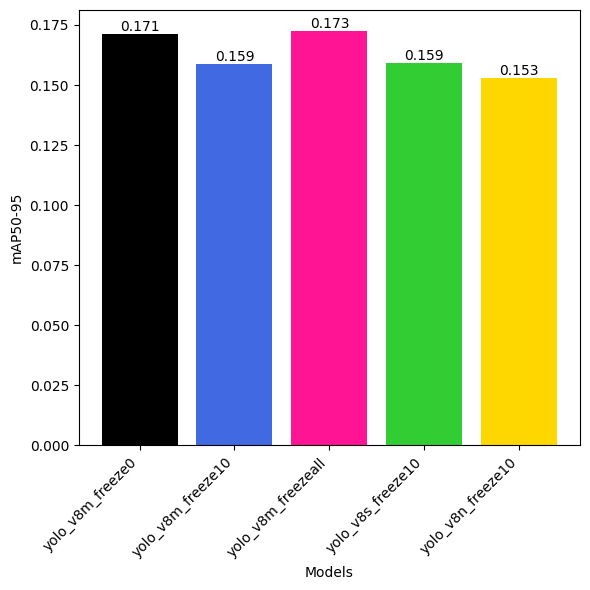

In [157]:
# Create the bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(df_results_mAP.columns, df_results_mAP.loc['mAP50-95'], color=colors)

plt.xlabel("Models")
plt.ylabel("mAP50-95")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center')

plt.show()


Combining insights from the confusion matrices, average precision values, and mAP50-95 scores, the best-performing models appear to be the YOLO v8 medium variant, with either the backbone (10 layers) or all layers frozen during training.

So far, we have evaluated models trained exclusively on images containing fractures. As a result, the confusion matrices lack true values for the "No Fracture Found" category. In the next step, we will assess the model’s performance on a balanced dataset that includes both images with fractures and those without.

The confusion matrix and the AP at an IoU of > 0.5 were best for the model where we froze the backbone - thus we are going to use this model in the next step.

# Object detection incl. images with no fractures

In [151]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo"

test_images_dir_all = f"{dataset_path}/images/test"

test_images_all = [f for f in os.listdir(test_images_dir_all)
               if f.lower().endswith((".jpg", ".png", ".jpeg"))]

models = ["yolo_v8m_freeze10.pt"]


len(test_images_all)

122


Loading Model: yolo_v8m_freeze10.pt


  0%|          | 0/122 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003023.jpg: 640x544 (no detections), 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


  1%|          | 1/122 [00:00<01:08,  1.76it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000385.jpg: 544x640 (no detections), 36.2ms
Speed: 3.9ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  2%|▏         | 2/122 [00:00<00:47,  2.55it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003459.jpg: 640x544 1 fractured, 36.7ms
Speed: 3.6ms preprocess, 36.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003588.jpg: 640x544 1 fractured, 34.7ms
Speed: 3.4ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  3%|▎         | 4/122 [00:00<00:21,  5.50it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000789.jpg: 544x640 (no detections), 33.9ms
Speed: 3.5ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000214.jpg: 512x640 1 fractured, 28.0ms
Speed: 4.6ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


  5%|▍         | 6/122 [00:01<00:20,  5.63it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003308.jpg: 640x544 1 fractured, 34.8ms
Speed: 3.5ms preprocess, 34.8ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003545.jpg: 640x544 (no detections), 33.5ms
Speed: 3.3ms preprocess, 33.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 8/122 [00:01<00:14,  7.61it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001912.jpg: 544x640 (no detections), 33.8ms
Speed: 3.3ms preprocess, 33.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003913.jpg: 544x640 (no detections), 32.8ms
Speed: 3.5ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


  8%|▊         | 10/122 [00:01<00:11,  9.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 24.8ms
Speed: 3.5ms preprocess, 24.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003490.jpg: 640x544 1 fractured, 23.8ms
Speed: 3.3ms preprocess, 23.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 23.8ms
Speed: 3.4ms preprocess, 23.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 11%|█         | 13/122 [00:01<00:08, 12.78it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003626.jpg: 640x544 1 fractured, 23.8ms
Speed: 3.3ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 21.2ms
Speed: 3.3ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002752.jpg: 640x544 (no detections), 20.8ms
Speed: 3.3ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 13%|█▎        | 16/122 [00:01<00:07, 14.93it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001637.jpg: 640x544 (no detections), 20.6ms
Speed: 3.2ms preprocess, 20.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003310.jpg: 640x544 (no detections), 20.4ms
Speed: 3.3ms preprocess, 20.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 20.3ms
Speed: 3.3ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 16%|█▌        | 19/122 [00:01<00:05, 17.26it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001651.jpg: 544x640 (no detections), 18.1ms
Speed: 3.3ms preprocess, 18.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003619.jpg: 640x544 1 fractured, 20.5ms
Speed: 3.2ms preprocess, 20.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000545.jpg: 544x640 (no detections), 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


 18%|█▊        | 22/122 [00:02<00:05, 19.31it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003168.jpg: 640x544 (no detections), 18.3ms
Speed: 3.4ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0004011.jpg: 640x544 (no detections), 17.4ms
Speed: 3.5ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 16.6ms
Speed: 3.7ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 20%|██        | 25/122 [00:02<00:04, 20.85it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003546.jpg: 640x544 (no detections), 16.4ms
Speed: 4.3ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001516.jpg: 544x640 1 fractured, 17.0ms
Speed: 3.4ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002852.jpg: 544x640 (no detections), 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 23%|██▎       | 28/122 [00:02<00:04, 22.64it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001412.jpg: 544x640 1 fractured, 17.0ms
Speed: 4.2ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003703.jpg: 640x544 1 fractured, 17.4ms
Speed: 4.7ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 16.4ms
Speed: 6.5ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 31/122 [00:02<00:03, 22.81it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 16.5ms
Speed: 6.1ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003331.jpg: 640x544 (no detections), 16.6ms
Speed: 3.8ms preprocess, 16.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003654.jpg: 640x544 1 fractured, 16.5ms
Speed: 3.7ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 34/122 [00:02<00:03, 23.14it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002788.jpg: 544x640 (no detections), 17.8ms
Speed: 3.3ms preprocess, 17.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000079.jpg: 640x512 (no detections), 14.3ms
Speed: 6.9ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003625.jpg: 640x544 1 fractured, 17.3ms
Speed: 3.6ms preprocess, 17.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 544)


 30%|███       | 37/122 [00:02<00:05, 14.21it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 16.4ms
Speed: 3.3ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003382.jpg: 640x544 1 fractured, 16.7ms
Speed: 3.3ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003972.jpg: 640x544 (no detections), 16.6ms
Speed: 3.9ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 40/122 [00:03<00:05, 15.96it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002082.jpg: 640x544 (no detections), 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002841.jpg: 640x544 (no detections), 16.5ms
Speed: 3.3ms preprocess, 16.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003399.jpg: 640x544 2 fractureds, 16.5ms
Speed: 3.5ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▌      | 43/122 [00:03<00:04, 17.85it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003712.jpg: 640x544 1 fractured, 16.5ms
Speed: 3.4ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 16.6ms
Speed: 3.3ms preprocess, 16.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000976.jpg: 640x544 (no detections), 23.6ms
Speed: 5.2ms preprocess, 23.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 46/122 [00:03<00:04, 18.91it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002709.jpg: 640x544 (no detections), 16.4ms
Speed: 3.8ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003723.jpg: 544x640 (no detections), 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)


 40%|████      | 49/122 [00:03<00:03, 20.18it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003645.jpg: 640x544 (no detections), 18.3ms
Speed: 3.3ms preprocess, 18.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002198.jpg: 640x544 (no detections), 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000529.jpg: 640x544 (no detections), 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 52/122 [00:03<00:03, 22.03it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003374.jpg: 640x544 1 fractured, 16.9ms
Speed: 3.2ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0004299.jpg: 640x544 (no detections), 16.9ms
Speed: 3.0ms preprocess, 16.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003628.jpg: 544x640 1 fractured, 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 45%|████▌     | 55/122 [00:03<00:02, 23.63it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003986.jpg: 640x544 (no detections), 17.6ms
Speed: 2.1ms preprocess, 17.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 16.7ms
Speed: 3.2ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 48%|████▊     | 58/122 [00:03<00:02, 24.78it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001429.jpg: 640x544 (no detections), 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003339.jpg: 640x544 1 fractured, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000974.jpg: 544x640 (no detections), 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 50%|█████     | 61/122 [00:03<00:02, 25.77it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003477.jpg: 640x544 1 fractured, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000998.jpg: 544x640 (no detections), 16.4ms
Speed: 2.9ms preprocess, 16.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003087.jpg: 640x544 (no detections), 16.8ms
Speed: 3.1ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 64/122 [00:04<00:02, 25.44it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001567.jpg: 544x640 1 fractured, 16.6ms
Speed: 2.1ms preprocess, 16.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003419.jpg: 640x544 1 fractured, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001910.jpg: 640x544 (no detections), 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▍    | 67/122 [00:04<00:02, 26.40it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001161.jpg: 544x640 (no detections), 17.4ms
Speed: 2.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002964.jpg: 640x544 (no detections), 17.4ms
Speed: 2.3ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003313.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.2ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 70/122 [00:04<00:01, 26.84it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003458.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003297.jpg: 640x544 2 fractureds, 16.4ms
Speed: 2.6ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 73/122 [00:04<00:01, 26.77it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001562.jpg: 544x640 (no detections), 16.5ms
Speed: 2.5ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003589.jpg: 640x544 1 fractured, 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001420.jpg: 640x544 (no detections), 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 76/122 [00:04<00:01, 26.86it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 16.6ms
Speed: 2.9ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0004265.jpg: 544x640 (no detections), 17.2ms
Speed: 2.6ms preprocess, 17.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002247.jpg: 640x544 (no detections), 17.2ms
Speed: 2.5ms preprocess, 17.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▍   | 79/122 [00:04<00:01, 26.87it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001424.jpg: 544x640 (no detections), 16.8ms
Speed: 4.2ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002183.jpg: 640x544 (no detections), 17.0ms
Speed: 2.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003321.jpg: 544x640 1 fractured, 17.0ms
Speed: 3.3ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 67%|██████▋   | 82/122 [00:04<00:01, 26.85it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003312.jpg: 640x544 (no detections), 17.7ms
Speed: 2.5ms preprocess, 17.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003510.jpg: 640x544 1 fractured, 16.8ms
Speed: 3.5ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 70%|██████▉   | 85/122 [00:04<00:01, 26.10it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003224.jpg: 640x544 (no detections), 16.7ms
Speed: 3.1ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003509.jpg: 640x544 2 fractureds, 16.7ms
Speed: 4.0ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003338.jpg: 640x544 3 fractureds, 16.7ms
Speed: 2.2ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 88/122 [00:04<00:01, 25.23it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003394.jpg: 640x544 (no detections), 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▍  | 91/122 [00:05<00:01, 26.18it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000439.jpg: 640x544 (no detections), 16.5ms
Speed: 2.1ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003311.jpg: 640x544 1 fractured, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003420.jpg: 544x640 1 fractured, 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 94/122 [00:05<00:01, 26.61it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002630.jpg: 544x640 (no detections), 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0004245.jpg: 544x640 1 fractured, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003685.jpg: 640x544 1 fractured, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 16.0ms
Speed: 3.1ms preprocess, 16.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 80%|████████  | 98/122 [00:05<00:00, 27.54it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003713.jpg: 640x544 1 fractured, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003466.jpg: 640x544 1 fractured, 16.2ms
Speed: 2.7ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002111.jpg: 544x640 (no detections), 16.7ms
Speed: 3.2ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


 83%|████████▎ | 101/122 [00:05<00:00, 26.90it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 17.0ms
Speed: 3.4ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000125.jpg: 640x512 (no detections), 13.8ms
Speed: 3.1ms preprocess, 13.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002726.jpg: 640x544 (no detections), 17.3ms
Speed: 2.3ms preprocess, 17.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 544)


 85%|████████▌ | 104/122 [00:05<00:00, 18.49it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002804.jpg: 544x640 (no detections), 16.6ms
Speed: 3.1ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 17.9ms
Speed: 3.5ms preprocess, 17.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002881.jpg: 640x544 (no detections), 16.5ms
Speed: 4.7ms preprocess, 16.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████▊ | 107/122 [00:05<00:00, 19.89it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000256.jpg: 640x512 (no detections), 13.7ms
Speed: 3.1ms preprocess, 13.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003075.jpg: 640x544 1 fractured, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 90%|█████████ | 110/122 [00:06<00:00, 16.39it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003342.jpg: 640x544 1 fractured, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003586.jpg: 640x544 2 fractureds, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003008.jpg: 640x544 (no detections), 15.9ms
Speed: 2.5ms preprocess, 15.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 93%|█████████▎| 113/122 [00:06<00:00, 18.15it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003341.jpg: 544x640 1 fractured, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003396.jpg: 640x544 1 fractured, 17.4ms
Speed: 3.6ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001204.jpg: 640x544 (no detections), 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 95%|█████████▌| 116/122 [00:06<00:00, 20.17it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000435.jpg: 544x640 (no detections), 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003659.jpg: 640x544 2 fractureds, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001478.jpg: 640x544 (no detections), 17.0ms
Speed: 2.6ms preprocess, 17.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 98%|█████████▊| 119/122 [00:06<00:00, 21.95it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003398.jpg: 640x544 1 fractured, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003520.jpg: 640x544 2 fractureds, 16.6ms
Speed: 3.3ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


100%|██████████| 122/122 [00:06<00:00, 18.71it/s]

Evaluating Model: yolo_v8m_freeze10.pt


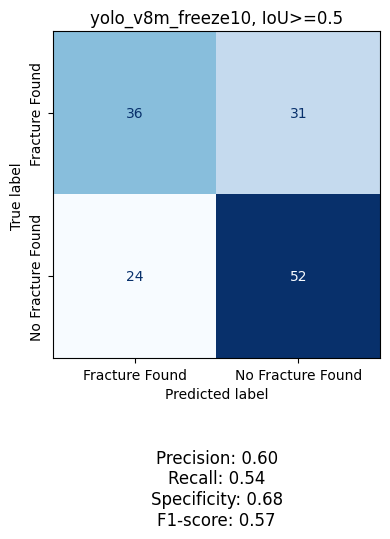

In [152]:
eval_results_no_fractures = evaluate_models(models, test_images_all, drive_model_dir, test_images_dir_all)

**Precision**: Of all predicted fractures, 60% were actually correct and we have a false positive rate of 24 cases, that were wrongly classified as fractures when they were actually normal.

**Recall**: Of all actual fractures, the model detected 54% correctly, but the model misses 46% of actual fractures (31 false negatives).

**Specificity**: The proportion of actual no-fracture cases that were correctly classified as not fractures. Thus, the model correctly avoids false alarms in 68% of non-fracture cases.

In [154]:
df_results_no_fractures = pd.DataFrame(eval_results_no_fractures)
print(f"mAP50-95: {df_results_no_fractures.mean()}")
df_results_no_fractures

mAP50-95: yolo_v8m_freeze10    0.14996
dtype: float64


,yolo_v8m_freeze10
0.50,0.455491
0.55,0.316638
0.60,0.268668
0.65,0.213708
0.70,0.138931
0.75,0.082665
0.80,0.022347
0.85,0.000574
0.90,0.000574
0.95,0.000000


Let's compare the average precision when using different test data: only fractures and those incl. also no fracture images.

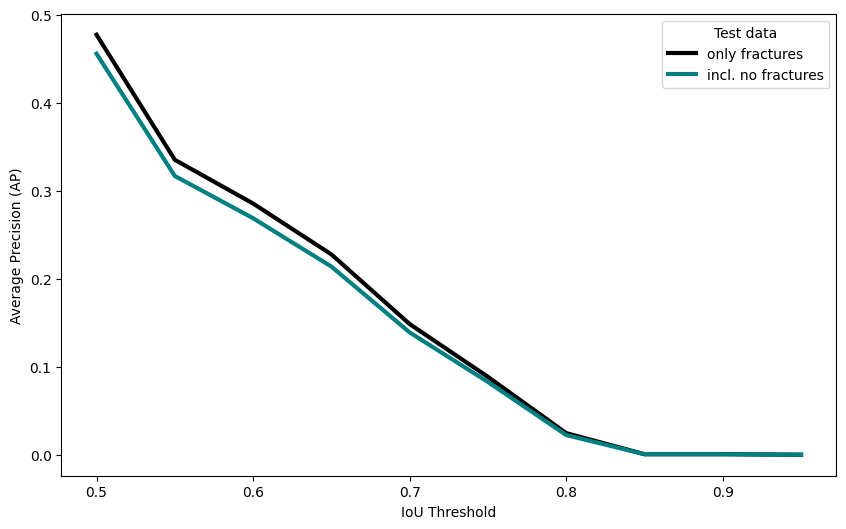

In [156]:
plt.figure(figsize=(10, 6))

# Plot the first column in black with linewidth 2
plt.plot(df_results.index, df_results['yolo_v8m_freeze10'], linestyle='-', color='black', linewidth=3, label='only fractures')
plt.plot(df_results_no_fractures.index, df_results_no_fractures['yolo_v8m_freeze10'], linestyle='-', color='teal', linewidth=3, label='incl. no fractures')


plt.xlabel("IoU Threshold")
plt.ylabel("Average Precision (AP)")
plt.legend(title="Test data", loc="upper right")
plt.grid(False)
plt.show()